# <center> Prueba Simulación de Eventos Discretos 


#### Diseñe y desarrolle un modelo y/o script que permita simular el siguiente caso real: En base a los datos del siguiente link https://educacion.gob.ec/wp-content/uploads/downloads/2012/08/AZUAY11.pdf, genere una simulación del ingresos de los estudiantes, para ello debemos escoger un establecimiento y en base a los docentes y estudiantes modelar el reingreso de los estudiantes en base a los siguientes datos:

- Solo se va a tener en cuanta uno de los planteles educativos(Escuela, colegio, universidad dentro del Azuay).
- Se tiene un promedio que el 90% de los docentes han sido vacunados y pueden realizar el proceso de ingreso en cada uno de los cursos.
- Dentro del procesos se tiene que alrededor del 5% - 10% de los estudiantes no podrán asistir debido a no presentar la vacuna/enfermedades.
- Los estudiantes solo pertenecen a una sola entidad educativa al igual que los docentes.
- Se va a tener un periodo de prueba de un mes, posterior a ello se realiza al azar al 10% de estudiantes una prueba PCR para validar que no estén contagiados.
- De la ultima el 2% de los estudiantes dan positivo por lo que se cierra el curso completo.
- Los estudiantes asisten cada semana y estos están en un horario de 6 horas ya sea diurno o nocturno.
- Tienen un receso 30 minutos dentro del establecimiento en donde se concentran todos los estudiantes y es un foco de contagio del 2%.

### DATOS DE LA ESCUELA:

- NOMBRE: UNIDAD EDUCATIVA 16 DE ABRIL
- Número de docentes: 15
- Número de cursos: 17
- Número de estudiantes: 346

In [31]:
import simpy
import random

Docentes=15
Estudiantes=346

NumDocentes = int((Docentes*90)/100)
print("Docentes vacunados: {}".format(NumDocentes))

n_aleatorio = random.randint(5, 10)
EstudiantesNoVacunados = int((Estudiantes*n_aleatorio)/100)
NumEstudiantesVacunados = Estudiantes - EstudiantesNoVacunados
print("Estudiantes vacunados: {}".format(NumEstudiantesVacunados))

Cursos                       = 17
NumEstudinateCurso = NumEstudiantesVacunados//Cursos
TIEMPO_SIMULACION            = 361*NumEstudiantesVacunados
Dia                          = 0
MES                          = 'SEPTIEMBRE'
RECREO                       = 30 
        

class Maestro:
    def __init__(self,nombre,infectado,examen):
        self.nombre      = nombre
        self.curso       = 'indefinido'
        self.institucion = 'UNIDAD EDUCATIVA 16 DE ABRIL'
        self.infectado   = infectado
        self.examen      = examen
    

class Estudiante:  
    def __init__(self,nombre,curso,infectado,examen):
        self.nombre    = nombre
        self.curso     = curso
        self.infectado = infectado
        self.examen    = examen    
    
    
def llenarMaestros():
    count=1
    lista_maestros = {}
    for i in range(0,NumDocentes):
        nombre = 'maestro_{}'.format(count)
        maestro = Maestro(nombre,0,0)
        lista_maestros[nombre]=maestro
        count+=1
    return lista_maestros


def llenarEstudiantes():
    count=1
    lista_estudiantes = {}
    cursosNivel = ['Octavo','Noveno','Decimo','Cuarto','Quinto','Sexto']
    cursosId = ['a','b','c']
    for i in cursosNivel:
        for j in cursosId:
            for z in range(0,NumEstudinateCurso+3 if i=='tercero' else NumEstudinateCurso):
                nombre='estudiante_{}'.format(count)
                estudiante = Estudiante(nombre,'{}_{}'.format(i,j),0,0)
                lista_estudiantes[nombre]=estudiante
                count+=1
    return lista_estudiantes


ListarEstudiantes = llenarEstudiantes()
ListarMaestros = llenarMaestros()
ListarPersonas = {**ListarEstudiantes,**ListarMaestros}
class Colegio():
    def __init__(self,environment):
        self.env          = environment
        self.pcr          = simpy.Resource(self.env,5)
        
    def proceso_clases(self):
        yield self.env.timeout(165)
    
    def proceso_receso(self):
        global RECREO
        yield self.env.timeout(RECREO)
        
    def proceso_prueba(self):
        yield self.env.timeout(2)
        
    def proceso_dia_clases(self,persona):
        yield self.env.process(self.proceso_clases())
        yield self.env.process(self.proceso_receso())
        if(random.randint(1,100)>98):
            persona.infectado=1
            ListarPersonas[persona.nombre] = persona
        yield self.env.process(self.proceso_clases())
    
    def proceso_pcr(self,persona):
        with self.pcr.request() as pcr:
            yield pcr
            yield self.env.process(self.proceso_prueba())
            if(random.randint(1,100)>(95 if persona.infectado==1 else 98)):
                persona.infectado=2
                ListarPersonas[persona.nombre] = persona

class Simulacion():
    
    def ejecutar_simulacion(self,env,filtrado):
        colegio = Colegio(env)
        global Dia
        
        if Dia < 31:
            print('{} Personas Regresan a clases Presenciales'.format(len(filtrado)))
            for i in filtrado.items():
                yield env.process(colegio.proceso_dia_clases(i[1]))
        else:
            print('se tomo una muestra de: {} para prueba PCR'.format(int(len(ListarPersonas)*0.1)))
            for i in random.choices(list(ListarPersonas.keys()),k=int(len(ListarPersonas)*0.1)):
                env.process(colegio.proceso_pcr(ListarPersonas[i]))
                
def filtrar_posibles_contagios():
    filtrado={}
    
    for i in ListarPersonas.items():
        if i[1].infectado!=1:
            filtrado[i[0]]=i[1]
    return filtrado


Dia=0
while (Dia<=30):
    Dia+=1
    print()
    print('Día {}'.format(Dia))
    env = simpy.Environment()
    simulacion = Simulacion()
    env.process(simulacion.ejecutar_simulacion(env,filtrar_posibles_contagios()))
    env.run(until=TIEMPO_SIMULACION)
    if(Dia==31):
        print('Infectados confirmados: {}'.format(len([i for i in ListarPersonas.items() if i[1].infectado ==2]))) 
    else:
        print('Posibles Infectados en el transcurso del día: {}'.format(len([i for i in ListarPersonas.items() if i[1].infectado ==1])))
    
   

Docentes vacunados: 13
Estudiantes vacunados: 315

Día 1
337 Personas Regresan a clases Presenciales
Posibles Infectados en el transcurso del día: 8

Día 2
329 Personas Regresan a clases Presenciales
Posibles Infectados en el transcurso del día: 17

Día 3
320 Personas Regresan a clases Presenciales
Posibles Infectados en el transcurso del día: 29

Día 4
308 Personas Regresan a clases Presenciales
Posibles Infectados en el transcurso del día: 34

Día 5
303 Personas Regresan a clases Presenciales
Posibles Infectados en el transcurso del día: 40

Día 6
297 Personas Regresan a clases Presenciales
Posibles Infectados en el transcurso del día: 47

Día 7
290 Personas Regresan a clases Presenciales
Posibles Infectados en el transcurso del día: 51

Día 8
286 Personas Regresan a clases Presenciales
Posibles Infectados en el transcurso del día: 58

Día 9
279 Personas Regresan a clases Presenciales
Posibles Infectados en el transcurso del día: 65

Día 10
272 Personas Regresan a clases Presenciales

In [32]:
import altair as alt
import pandas as pd
import plotly.express as px
import plotly
plotly.offline.init_notebook_mode(connected=True)

print('Personas en la institución: {}'.format(len(ListarPersonas)))
print('Total de estudiantes: {}'.format(len(ListarEstudiantes)))
print('Total de maestros: {}'.format(len(ListarMaestros)))
print('Personas con posible contagio: {}'.format(len([i for i in ListarPersonas.items() if i[1].infectado ==1])))
print('Personas contagiadas confirmadas: {}'.format(len([i for i in ListarPersonas.items() if i[1].infectado ==2])))
print('Cursos que se cierran: {}'.format(list(pd.DataFrame([i[1].curso for i in ListarPersonas.items() if i[1].infectado ==2],columns=['cursos'])['cursos'].unique())))

Personas en la institución: 337
Total de estudiantes: 324
Total de maestros: 13
Personas con posible contagio: 156
Personas contagiadas confirmadas: 1
Cursos que se cierran: ['Octavo_b']


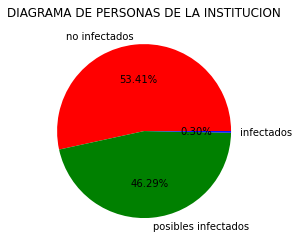

,description,value
0,no infectados,0.534125
1,posibles infectados,0.462908
2,infectados,0.002967


In [36]:
import matplotlib.pyplot as plt
no_infectados = 0
infectados    = 0
po_infectados = 0
for i in ListarPersonas.items():
    if i[1].infectado==1:
        po_infectados+=1
    elif i[1].infectado==2:
        infectados+=1
    else:
        no_infectados+=1



etiquetas = ['no infectados','posibles infectados','infectados']
valores = [no_infectados/len(ListarPersonas),po_infectados/len(ListarPersonas),infectados/len(ListarPersonas)]
colores = ['red','green','blue']
plt.pie(x=valores, labels=etiquetas, colors = colores,  autopct='%1.2f%%')
plt.title('DIAGRAMA DE PERSONAS DE LA INSTITUCION')
plt.show()


df_general = pd.DataFrame([('no infectados',no_infectados/len(ListarPersonas)),
                           ('posibles infectados',po_infectados/len(ListarPersonas)),
                          ('infectados',infectados/len(ListarPersonas))],columns=['description','value'])

df_general